In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [192]:
startup = pd.read_excel("C://플랫폼 SME 연구센터/스타트업 데이터 업데이트/23-11-03_스타트업 데이터.xlsx", sheet_name=2, header=1, index_col=0)
startup

,registration_number,name,estdate,address_city,address_district,address_detail,service,service_details,country,category1,...,fd2_edu_schoolname3,fd2_edu_major3,fd2_career_firmname1,fd2_career_rank1,fd2_career_job1,fd2_career_dur1,fd2_career_firmname2,fd2_career_rank2,fd2_career_job2,fd2_career_dur2
id,,,,,,,,,,,,,,,,,,,,,
1,178-86-00272,가브린트,2015-11-05,제주,제주시,"내도1길 23, 320호",와라페이,QR코드 기반 간편결제 서비스,한국,결제,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,384-81-01454,가이드라이브,2019-05-22,서울,중구,"청계천로 40, 812호",가이드라이브,"가이드/도슨트 매니지먼트 기반의 투어 서비스, 랜선 투어",한국,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,156-81-00883,가치공간,2018-01-01,서울,마포구,"백범로31길 21, 808호",가치공간,백화점 유휴공간 공유 팝업 스토어 플랫폼,한국,리얼타임 커뮤니케이션,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,413-81-06460,갓차모빌라이즈(갓차),2016-08-24,부산,수영구,"광남로 214, 5층",갓차,정기구독형 방문 세차 중개 플랫폼,한국,리얼타임 커뮤니케이션,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,287-87-01121,같다,2018-03-20,서울,성동구,성수2가3동 277-43번지 4층 405비호,빼기,모바일 대형폐기물 수거 플랫폼,한국,리얼타임 커뮤니케이션,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3910,821-81-01725,호텔가이드,2019-12-04,서울,노원구,"동일로 1025, 4층",호텔가,단골추가 숙박예약 플랫폼,한국,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3911,752-87-01834,훌템,2020-12-28,경기도,군포시,"군포첨단산업2로22번길 5, 617호",뽀얀닷컴,이동형 매트리스 세탁 서비스,한국,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3912,752-86-01410,휴니버스글로벌,2019-06-12,서울,성북구,"안암로81, 2층",정밀의료 병원정보시스템,클라우드기반 병의원 정보시스템,한국,클라우드,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
startup['platform_type'].value_counts()

전자상거래         406
정보검색          269
금융/결제         134
미디어/엔터테인먼트    126
의사소통          107
자산공유          106
인적서비스 생활      100
교육             84
인적서비스 전문       50
구인구직/채용        35
Name: platform_type, dtype: int64

In [193]:
startup['est_dt'] = startup['estdate'].dt.year # 설립연도만 열로 추가
startup['ed_dt'] = startup['end_dt'].dt.year # 폐업연도만 열로 추가

In [194]:
startup['ed_dt'].value_counts()

2022.0    84
2023.0    70
2021.0    41
2020.0    30
2019.0    20
2018.0     7
2017.0     2
2015.0     1
Name: ed_dt, dtype: int64

In [195]:
startup['ed_dt'] = startup['ed_dt'].replace(2023,np.NaN) # 2023년 폐업 기업은 값 제거

In [196]:
startup['ed_dt'].value_counts()

2022.0    84
2021.0    41
2020.0    30
2019.0    20
2018.0     7
2017.0     2
2015.0     1
Name: ed_dt, dtype: int64

In [197]:
startup['event'] = startup['ed_dt'].isnull().apply(lambda x: 0 if x else 1) # 폐업연도가 없는 계속 기업엔 0, 폐업 기업엔 1 

In [198]:
for i in range(len(startup.filter(like='_date').columns)): # 투자연도만 표시한 열 추가
    startup[f'invest_dt_{i}'] = startup.filter(like='_date').iloc[:,i].dt.year

In [199]:
startup

,registration_number,name,estdate,address_city,address_district,address_detail,service,service_details,country,category1,...,invest_dt_2,invest_dt_3,invest_dt_4,invest_dt_5,invest_dt_6,invest_dt_7,invest_dt_8,invest_dt_9,invest_dt_10,invest_dt_11
id,,,,,,,,,,,,,,,,,,,,,
1,178-86-00272,가브린트,2015-11-05,제주,제주시,"내도1길 23, 320호",와라페이,QR코드 기반 간편결제 서비스,한국,결제,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,384-81-01454,가이드라이브,2019-05-22,서울,중구,"청계천로 40, 812호",가이드라이브,"가이드/도슨트 매니지먼트 기반의 투어 서비스, 랜선 투어",한국,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,156-81-00883,가치공간,2018-01-01,서울,마포구,"백범로31길 21, 808호",가치공간,백화점 유휴공간 공유 팝업 스토어 플랫폼,한국,리얼타임 커뮤니케이션,...,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,413-81-06460,갓차모빌라이즈(갓차),2016-08-24,부산,수영구,"광남로 214, 5층",갓차,정기구독형 방문 세차 중개 플랫폼,한국,리얼타임 커뮤니케이션,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,287-87-01121,같다,2018-03-20,서울,성동구,성수2가3동 277-43번지 4층 405비호,빼기,모바일 대형폐기물 수거 플랫폼,한국,리얼타임 커뮤니케이션,...,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3910,821-81-01725,호텔가이드,2019-12-04,서울,노원구,"동일로 1025, 4층",호텔가,단골추가 숙박예약 플랫폼,한국,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3911,752-87-01834,훌템,2020-12-28,경기도,군포시,"군포첨단산업2로22번길 5, 617호",뽀얀닷컴,이동형 매트리스 세탁 서비스,한국,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3912,752-86-01410,휴니버스글로벌,2019-06-12,서울,성북구,"안암로81, 2층",정밀의료 병원정보시스템,클라우드기반 병의원 정보시스템,한국,클라우드,...,2020.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
startup = startup.drop(index=3914) # 2023년 설립 기업 제거

In [ ]:
startup['cld_dt'] = startup['ed_dt'] # 폐업연도가 들어간 열 복사

In [201]:
startup['cld_dt'] = startup['cld_dt'].fillna(2022) # 영업 중인 기업에 관측기간 말 연도 삽입

In [202]:
startup['time'] = startup['cld_dt']-startup['est_dt'] # 생존기간 계산

In [203]:
startup_1 = startup.drop(index=[1691, 1709, 3216, 3517, 3727]) # 폐업 후 잔존 기업 제거

In [301]:
print(startup_1.columns[0:10])
print(startup_1.columns[10:20])
print(startup_1.columns[177:195])

Index(['registration_number', 'name', 'estdate', 'address_city',
       'address_district', 'address_detail', 'service', 'service_details',
       'country', 'category1'],
      dtype='object')
Index(['       ', 'category3', 'category', 'o2o', 'listed', 'capitalstock',
       'Unnamed: 17', 'Unnamed: 18', 'platform', 'platform_type'],
      dtype='object')
Index(['fd2_career_dur2', 'est_dt', 'ed_dt', 'event', 'cld_dt', 'invest_dt_0',
       'invest_dt_1', 'invest_dt_2', 'invest_dt_3', 'invest_dt_4',
       'invest_dt_5', 'invest_dt_6', 'invest_dt_7', 'invest_dt_8',
       'invest_dt_9', 'invest_dt_10', 'invest_dt_11', 'time'],
      dtype='object')


In [204]:
sa_df2 = pd.merge(startup_1.iloc[:,[1, 18]],startup_1.iloc[:,178:195], on='id') # 플/비플, 설립연도, 폐업연도, 사건발생여부, 
                                                                                # 관측 종료 시점, 투자연도 

In [205]:
sa_df2

,name,platform,est_dt,ed_dt,event,cld_dt,invest_dt_0,invest_dt_1,invest_dt_2,invest_dt_3,invest_dt_4,invest_dt_5,invest_dt_6,invest_dt_7,invest_dt_8,invest_dt_9,invest_dt_10,invest_dt_11,time
id,,,,,,,,,,,,,,,,,,,
1,가브린트,비플랫폼,2015,NaN,0,2022.0,NaN,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
2,가이드라이브,플랫폼,2019,NaN,0,2022.0,2019.0,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3,가치공간,플랫폼,2018,NaN,0,2022.0,NaN,NaN,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
4,갓차모빌라이즈(갓차),플랫폼,2016,NaN,0,2022.0,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
5,같다,플랫폼,2018,NaN,0,2022.0,2019.0,2019.0,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3909,헬퍼로보틱스,비플랫폼,2021,NaN,0,2022.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3910,호텔가이드,플랫폼,2019,NaN,0,2022.0,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3911,훌템,비플랫폼,2020,NaN,0,2022.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [206]:
sa_df2_in19y = sa_df2[(sa_df2['est_dt']<2019) & (sa_df2['est_dt']>1999)]

In [209]:
sa_df2_in21y = sa_df2[(sa_df2['est_dt']<2023) & (sa_df2['est_dt']>1999)]

# 폐업 기업수

## 23년 폐업(23.01~23.10)

In [101]:
print(sa_df2_in21y[sa_df2_in21y['ed_dt']==2023]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[sa_df2_in21y['ed_dt']==2023]['est_dt'].value_counts().sum())

2021     3
2020     4
2019    17
2018     7
2017    13
2016    11
2015     8
2014     2
2012     1
2011     2
2010     1
Name: est_dt, dtype: int64
총 기업수: 69


## 22년 폐업

### 00~21년 설립

In [212]:
print(sa_df2_in21y[sa_df2_in21y['ed_dt']==2022]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[sa_df2_in21y['ed_dt']==2022]['est_dt'].value_counts().sum())
print("플랫폼 기업")
print(sa_df2_in21y[(sa_df2_in21y['cld_dt']==2022) & (sa_df2_in21y['event']==1)]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[(sa_df2_in21y['cld_dt']==2022) &(sa_df2_in21y['event']==1)]['est_dt'].value_counts().sum())
print("비플랫폼 기업")
print(sa_df2_in21y[(sa_df2_in21y['ed_dt']==2022) & (sa_df2_in21y['platform']=='플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[(sa_df2_in21y['ed_dt']==2022) & (sa_df2_in21y['platform']=='플랫폼')]['est_dt'].value_counts().sum())

2021     5
2020    10
2019     8
2018    12
2017    13
2016    10
2015     7
2014     5
2013     4
2012     3
2010     1
2001     1
2000     1
Name: est_dt, dtype: int64
총 기업수: 80
플랫폼 기업
2021     5
2020    10
2019     8
2018    12
2017    13
2016    10
2015     7
2014     5
2013     4
2012     3
2010     1
2001     1
2000     1
Name: est_dt, dtype: int64
총 기업수: 80
비플랫폼 기업
2021    3
2020    5
2019    6
2018    4
2017    3
2016    6
2015    3
2014    3
2013    1
2012    2
2001    1
Name: est_dt, dtype: int64
총 기업수: 37


In [147]:
print(sa_df2_in21y[(sa_df2_in21y['cld_dt']==2022) & (sa_df2_in21y['event']==1)]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[(sa_df2_in21y['cld_dt']==2022) &(sa_df2_in21y['event']==1)]['est_dt'].value_counts().sum())

2021     5
2020    10
2019     8
2018    12
2017    13
2016    10
2015     7
2014     5
2013     4
2012     3
2010     1
2001     1
2000     1
Name: est_dt, dtype: int64
총 기업수: 80


### 00~18년 설립

In [152]:
print(sa_df2_in19y[(sa_df2_in19y['cld_dt']==2022) & (sa_df2_in19y['event']==1)]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in19y[(sa_df2_in19y['cld_dt']==2022) & (sa_df2_in19y['event']==1)]['est_dt'].value_counts().sum())
print(" ")
print("플랫폼 기업")
print(sa_df2_in19y[(sa_df2_in19y['ed_dt']==2022) & (sa_df2_in19y['platform']=='플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in19y[(sa_df2_in19y['ed_dt']==2022) & (sa_df2_in19y['platform']=='플랫폼')]['est_dt'].value_counts().sum())
print(" ")
print("비플랫폼 기업")
print(sa_df2_in19y[(sa_df2_in19y['ed_dt']==2022) & (sa_df2_in19y['platform']=='비플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in19y[(sa_df2_in19y['ed_dt']==2022) & (sa_df2_in19y['platform']=='비플랫폼')]['est_dt'].value_counts().sum())

2018    12
2017    13
2016    10
2015     7
2014     5
2013     4
2012     3
2010     1
2001     1
2000     1
Name: est_dt, dtype: int64
총 기업수: 57
 
플랫폼 기업
2018    4
2017    3
2016    6
2015    3
2014    3
2013    1
2012    2
2001    1
Name: est_dt, dtype: int64
총 기업수: 23
 
비플랫폼 기업
2018     8
2017    10
2016     4
2015     4
2014     2
2013     3
2012     1
2010     1
2000     1
Name: est_dt, dtype: int64
총 기업수: 34


## 21년 폐업

### 00~21년 설립

In [213]:
print(sa_df2_in21y[sa_df2_in21y['ed_dt']==2021]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[sa_df2_in21y['ed_dt']==2021]['est_dt'].value_counts().sum())
print("플랫폼 기업")
print(sa_df2_in21y[(sa_df2_in21y['ed_dt']==2021) & (sa_df2_in21y['platform']=='플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[(sa_df2_in21y['ed_dt']==2021) & (sa_df2_in21y['platform']=='플랫폼')]['est_dt'].value_counts().sum())
print("비플랫폼 기업")
print(sa_df2_in21y[(sa_df2_in21y['ed_dt']==2021) & (sa_df2_in21y['platform']=='비플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[(sa_df2_in21y['ed_dt']==2021) & (sa_df2_in21y['platform']=='비플랫폼')]['est_dt'].value_counts().sum())

2021     1
2020     1
2019     6
2018     4
2017     5
2016    11
2015     3
2014     4
2013     1
2012     2
2011     2
2009     1
Name: est_dt, dtype: int64
총 기업수: 41
플랫폼 기업
2019    2
2018    2
2017    3
2016    3
2015    2
2014    2
2011    2
Name: est_dt, dtype: int64
총 기업수: 16
비플랫폼 기업
2021    1
2020    1
2019    4
2018    2
2017    2
2016    8
2015    1
2014    2
2013    1
2012    2
2009    1
Name: est_dt, dtype: int64
총 기업수: 25


### 00~18년 설립

In [154]:
print(sa_df2_in19y[(sa_df2_in19y['cld_dt']==2021) & (sa_df2_in19y['event']==1)]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in19y[(sa_df2_in19y['cld_dt']==2021) & (sa_df2_in19y['event']==1)]['est_dt'].value_counts().sum())
print(" ")
print("플랫폼 기업")
print(sa_df2_in19y[(sa_df2_in19y['ed_dt']==2021) & (sa_df2_in19y['platform']=='플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in19y[(sa_df2_in19y['ed_dt']==2021) & (sa_df2_in19y['platform']=='플랫폼')]['est_dt'].value_counts().sum())
print(" ")
print("비플랫폼 기업")
print(sa_df2_in19y[(sa_df2_in19y['ed_dt']==2021) & (sa_df2_in19y['platform']=='비플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in19y[(sa_df2_in19y['ed_dt']==2021) & (sa_df2_in19y['platform']=='비플랫폼')]['est_dt'].value_counts().sum())

2018     4
2017     5
2016    11
2015     3
2014     4
2013     1
2012     2
2011     2
2009     1
Name: est_dt, dtype: int64
총 기업수: 33
 
플랫폼 기업
2018    2
2017    3
2016    3
2015    2
2014    2
2011    2
Name: est_dt, dtype: int64
총 기업수: 14
 
비플랫폼 기업
2018    2
2017    2
2016    8
2015    1
2014    2
2013    1
2012    2
2009    1
Name: est_dt, dtype: int64
총 기업수: 19


## 20년 폐업

In [214]:
print(sa_df2_in21y[sa_df2_in21y['ed_dt']==2020]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[sa_df2_in21y['ed_dt']==2020]['est_dt'].value_counts().sum())
print("플랫폼 기업")
print(sa_df2_in21y[(sa_df2_in21y['ed_dt']==2020) & (sa_df2_in21y['platform']=='플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[(sa_df2_in21y['ed_dt']==2020) & (sa_df2_in21y['platform']=='플랫폼')]['est_dt'].value_counts().sum())
print("비플랫폼 기업")
print(sa_df2_in21y[(sa_df2_in21y['ed_dt']==2020) & (sa_df2_in21y['platform']=='비플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[(sa_df2_in21y['ed_dt']==2020) & (sa_df2_in21y['platform']=='비플랫폼')]['est_dt'].value_counts().sum())

2019    3
2018    3
2017    6
2016    6
2015    4
2014    2
2013    4
2011    1
2005    1
Name: est_dt, dtype: int64
총 기업수: 30
플랫폼 기업
2019    2
2018    1
2017    1
2016    3
2015    1
2014    1
2013    3
Name: est_dt, dtype: int64
총 기업수: 12
비플랫폼 기업
2019    1
2018    2
2017    5
2016    3
2015    3
2014    1
2013    1
2011    1
2005    1
Name: est_dt, dtype: int64
총 기업수: 18


## 19년 폐업

In [215]:
print(sa_df2_in21y[sa_df2_in21y['ed_dt']==2019]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[sa_df2_in21y['ed_dt']==2019]['est_dt'].value_counts().sum())
print("플랫폼 기업")
print(sa_df2_in21y[(sa_df2_in21y['ed_dt']==2019) & (sa_df2_in21y['platform']=='플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[(sa_df2_in21y['ed_dt']==2019) & (sa_df2_in21y['platform']=='플랫폼')]['est_dt'].value_counts().sum())
print("비플랫폼 기업")
print(sa_df2_in21y[(sa_df2_in21y['ed_dt']==2019) & (sa_df2_in21y['platform']=='비플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[(sa_df2_in21y['ed_dt']==2019) & (sa_df2_in21y['platform']=='비플랫폼')]['est_dt'].value_counts().sum())

2018    2
2017    3
2016    4
2015    9
2013    1
2012    1
Name: est_dt, dtype: int64
총 기업수: 20
플랫폼 기업
2018    2
2017    1
2016    1
2015    3
Name: est_dt, dtype: int64
총 기업수: 7
비플랫폼 기업
2017    2
2016    3
2015    6
2013    1
2012    1
Name: est_dt, dtype: int64
총 기업수: 13


## 18년 폐업

In [216]:
print(sa_df2_in21y[sa_df2_in21y['ed_dt']==2018]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[sa_df2_in21y['ed_dt']==2018]['est_dt'].value_counts().sum())
print("플랫폼 기업")
print(sa_df2_in21y[(sa_df2_in21y['ed_dt']==2018) & (sa_df2_in21y['platform']=='플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[(sa_df2_in21y['ed_dt']==2018) & (sa_df2_in21y['platform']=='플랫폼')]['est_dt'].value_counts().sum())
print("비플랫폼 기업")
print(sa_df2_in21y[(sa_df2_in21y['ed_dt']==2018) & (sa_df2_in21y['platform']=='비플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("총 기업수:",sa_df2_in21y[(sa_df2_in21y['ed_dt']==2018) & (sa_df2_in21y['platform']=='비플랫폼')]['est_dt'].value_counts().sum())

2018    1
2017    1
2016    1
2015    1
2014    1
2013    2
Name: est_dt, dtype: int64
총 기업수: 7
플랫폼 기업
2016    1
2014    1
2013    1
Name: est_dt, dtype: int64
총 기업수: 3
비플랫폼 기업
2018    1
2017    1
2015    1
2013    1
Name: est_dt, dtype: int64
총 기업수: 4


# 설립 기업수

## 22년 설립

In [146]:
print("전체:",sa_df2[sa_df2['est_dt']==2022]['est_dt'].value_counts().sort_index(ascending=False))
print("플랫폼:",sa_df2[(sa_df2['est_dt']==2022) & (sa_df2['platform']=='플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("비플랫폼:",sa_df2[(sa_df2['est_dt']==2022) & (sa_df2['platform']=='비플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))

전체: 2022    79
Name: est_dt, dtype: int64
플랫폼: 2022    27
Name: est_dt, dtype: int64
비플랫폼: 2022    52
Name: est_dt, dtype: int64


In [360]:
print("전체:",sa_df2[(sa_df2['est_dt']==2022) & ((sa_df2['invest_dt_0']==2022) | (sa_df2['invest_dt_1']==2022) | 
 (sa_df2['invest_dt_2']==2022) | (sa_df2['invest_dt_3']==2022) | (sa_df2['invest_dt_4']==2022) | 
 (sa_df2['invest_dt_5']==2022) | (sa_df2['invest_dt_6']==2022) | (sa_df2['invest_dt_7']==2022) |
 (sa_df2['invest_dt_8']==2022) | (sa_df2['invest_dt_9']==2022) | (sa_df2['invest_dt_10']==2022))]['est_dt'].value_counts())
print("플랫폼:",sa_df2[(sa_df2['est_dt']==2022) & (sa_df2['platform']=='플랫폼') & ((sa_df2['invest_dt_0']==2022) | (sa_df2['invest_dt_1']==2022) | 
 (sa_df2['invest_dt_2']==2022) | (sa_df2['invest_dt_3']==2022) | (sa_df2['invest_dt_4']==2022) | 
 (sa_df2['invest_dt_5']==2022) | (sa_df2['invest_dt_6']==2022) | (sa_df2['invest_dt_7']==2022) |
 (sa_df2['invest_dt_8']==2022) | (sa_df2['invest_dt_9']==2022) | (sa_df2['invest_dt_10']==2022))]['est_dt'].value_counts())
print("비플랫폼:",sa_df2[(sa_df2['est_dt']==2022) & (sa_df2['platform']=='비플랫폼') & ((sa_df2['invest_dt_0']==2022) | (sa_df2['invest_dt_1']==2022) | 
 (sa_df2['invest_dt_2']==2022) | (sa_df2['invest_dt_3']==2022) | (sa_df2['invest_dt_4']==2022) | 
 (sa_df2['invest_dt_5']==2022) | (sa_df2['invest_dt_6']==2022) | (sa_df2['invest_dt_7']==2022) |
 (sa_df2['invest_dt_8']==2022) | (sa_df2['invest_dt_9']==2022) | (sa_df2['invest_dt_10']==2022))]['est_dt'].value_counts())

전체: 2022    74
Name: est_dt, dtype: int64
플랫폼: 2022    25
Name: est_dt, dtype: int64
비플랫폼: 2022    49
Name: est_dt, dtype: int64


## 21년 설립

In [147]:
print("전체:",sa_df2_in21y[sa_df2_in21y['est_dt']==2021]['est_dt'].value_counts().sort_index(ascending=False))
print("플랫폼:",sa_df2_in21y[(sa_df2_in21y['est_dt']==2021) & (sa_df2_in21y['platform']=='플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("비플랫폼:",sa_df2_in21y[(sa_df2_in21y['est_dt']==2021) & (sa_df2_in21y['platform']=='비플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))

전체: 2021    322
Name: est_dt, dtype: int64
플랫폼: 2021    116
Name: est_dt, dtype: int64
비플랫폼: 2021    206
Name: est_dt, dtype: int64


In [359]:
print("전체:",sa_df2[(sa_df2['est_dt']==2021) & ((sa_df2['invest_dt_0']==2021) | (sa_df2['invest_dt_1']==2021) | 
 (sa_df2['invest_dt_2']==2021) | (sa_df2['invest_dt_3']==2021) | (sa_df2['invest_dt_4']==2021) | 
 (sa_df2['invest_dt_5']==2021) | (sa_df2['invest_dt_6']==2021) | (sa_df2['invest_dt_7']==2021) |
 (sa_df2['invest_dt_8']==2021) | (sa_df2['invest_dt_9']==2021) | (sa_df2['invest_dt_10']==2021))]['est_dt'].value_counts())
print("플랫폼:",sa_df2[(sa_df2['est_dt']==2021) & (sa_df2['platform']=='플랫폼') & ((sa_df2['invest_dt_0']==2021) | (sa_df2['invest_dt_1']==2021) | 
 (sa_df2['invest_dt_2']==2021) | (sa_df2['invest_dt_3']==2021) | (sa_df2['invest_dt_4']==2021) | 
 (sa_df2['invest_dt_5']==2021) | (sa_df2['invest_dt_6']==2021) | (sa_df2['invest_dt_7']==2021) |
 (sa_df2['invest_dt_8']==2021) | (sa_df2['invest_dt_9']==2021) | (sa_df2['invest_dt_10']==2021))]['est_dt'].value_counts())
print("비플랫폼:",sa_df2[(sa_df2['est_dt']==2021) & (sa_df2['platform']=='비플랫폼') & ((sa_df2['invest_dt_0']==2021) | (sa_df2['invest_dt_1']==2021) | 
 (sa_df2['invest_dt_2']==2021) | (sa_df2['invest_dt_3']==2021) | (sa_df2['invest_dt_4']==2021) | 
 (sa_df2['invest_dt_5']==2021) | (sa_df2['invest_dt_6']==2021) | (sa_df2['invest_dt_7']==2021) |
 (sa_df2['invest_dt_8']==2021) | (sa_df2['invest_dt_9']==2021) | (sa_df2['invest_dt_10']==2021))]['est_dt'].value_counts())

전체: 2021    166
Name: est_dt, dtype: int64
플랫폼: 2021    66
Name: est_dt, dtype: int64
비플랫폼: 2021    100
Name: est_dt, dtype: int64


## 20년 설립

In [149]:
print("전체:",sa_df2_in21y[sa_df2_in21y['est_dt']==2020]['est_dt'].value_counts().sort_index(ascending=False))
print("플랫폼:",sa_df2_in21y[(sa_df2_in21y['est_dt']==2020) & (sa_df2_in21y['platform']=='플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("비플랫폼:",sa_df2_in21y[(sa_df2_in21y['est_dt']==2020) & (sa_df2_in21y['platform']=='비플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))

전체: 2020    466
Name: est_dt, dtype: int64
플랫폼: 2020    175
Name: est_dt, dtype: int64
비플랫폼: 2020    291
Name: est_dt, dtype: int64


In [358]:
print("전체:",sa_df2[(sa_df2['est_dt']==2020) & ((sa_df2['invest_dt_0']==2020) | (sa_df2['invest_dt_1']==2020) | 
 (sa_df2['invest_dt_2']==2020) | (sa_df2['invest_dt_3']==2020) | (sa_df2['invest_dt_4']==2020) | 
 (sa_df2['invest_dt_5']==2020) | (sa_df2['invest_dt_6']==2020) | (sa_df2['invest_dt_7']==2020) |
 (sa_df2['invest_dt_8']==2020) | (sa_df2['invest_dt_9']==2020) | (sa_df2['invest_dt_10']==2020))]['est_dt'].value_counts())
print("플랫폼:",sa_df2[(sa_df2['est_dt']==2020) & (sa_df2['platform']=='플랫폼') & ((sa_df2['invest_dt_0']==2020) | (sa_df2['invest_dt_1']==2020) | 
 (sa_df2['invest_dt_2']==2020) | (sa_df2['invest_dt_3']==2020) | (sa_df2['invest_dt_4']==2020) | 
 (sa_df2['invest_dt_5']==2020) | (sa_df2['invest_dt_6']==2020) | (sa_df2['invest_dt_7']==2020) |
 (sa_df2['invest_dt_8']==2020) | (sa_df2['invest_dt_9']==2020) | (sa_df2['invest_dt_10']==2020))]['est_dt'].value_counts())
print("비플랫폼:",sa_df2[(sa_df2['est_dt']==2020) & (sa_df2['platform']=='비플랫폼') & ((sa_df2['invest_dt_0']==2020) | (sa_df2['invest_dt_1']==2020) | 
 (sa_df2['invest_dt_2']==2020) | (sa_df2['invest_dt_3']==2020) | (sa_df2['invest_dt_4']==2020) | 
 (sa_df2['invest_dt_5']==2020) | (sa_df2['invest_dt_6']==2020) | (sa_df2['invest_dt_7']==2020) |
 (sa_df2['invest_dt_8']==2020) | (sa_df2['invest_dt_9']==2020) | (sa_df2['invest_dt_10']==2020))]['est_dt'].value_counts())

전체: 2020    174
Name: est_dt, dtype: int64
플랫폼: 2020    75
Name: est_dt, dtype: int64
비플랫폼: 2020    99
Name: est_dt, dtype: int64


## 19년 설립

In [150]:
print("전체:",sa_df2_in21y[sa_df2_in21y['est_dt']==2019]['est_dt'].value_counts().sort_index(ascending=False))
print("플랫폼:",sa_df2_in21y[(sa_df2_in21y['est_dt']==2019) & (sa_df2_in21y['platform']=='플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("비플랫폼:",sa_df2_in21y[(sa_df2_in21y['est_dt']==2019) & (sa_df2_in21y['platform']=='비플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))

전체: 2019    541
Name: est_dt, dtype: int64
플랫폼: 2019    219
Name: est_dt, dtype: int64
비플랫폼: 2019    322
Name: est_dt, dtype: int64


In [357]:
print("전체:",sa_df2[(sa_df2['est_dt']==2019) & ((sa_df2['invest_dt_0']==2019) | (sa_df2['invest_dt_1']==2019) | 
 (sa_df2['invest_dt_2']==2019) | (sa_df2['invest_dt_3']==2019) | (sa_df2['invest_dt_4']==2019) | 
 (sa_df2['invest_dt_5']==2019) | (sa_df2['invest_dt_6']==2019) | (sa_df2['invest_dt_7']==2019) |
 (sa_df2['invest_dt_8']==2019) | (sa_df2['invest_dt_9']==2019) | (sa_df2['invest_dt_10']==2019))]['est_dt'].value_counts())
print("플랫폼:",sa_df2[(sa_df2['est_dt']==2019) & (sa_df2['platform']=='플랫폼') & ((sa_df2['invest_dt_0']==2019) | (sa_df2['invest_dt_1']==2019) | 
 (sa_df2['invest_dt_2']==2019) | (sa_df2['invest_dt_3']==2019) | (sa_df2['invest_dt_4']==2019) | 
 (sa_df2['invest_dt_5']==2019) | (sa_df2['invest_dt_6']==2019) | (sa_df2['invest_dt_7']==2019) |
 (sa_df2['invest_dt_8']==2019) | (sa_df2['invest_dt_9']==2019) | (sa_df2['invest_dt_10']==2019))]['est_dt'].value_counts())
print("비플랫폼:",sa_df2[(sa_df2['est_dt']==2019) & (sa_df2['platform']=='비플랫폼') & ((sa_df2['invest_dt_0']==2019) | (sa_df2['invest_dt_1']==2019) | 
 (sa_df2['invest_dt_2']==2019) | (sa_df2['invest_dt_3']==2019) | (sa_df2['invest_dt_4']==2019) | 
 (sa_df2['invest_dt_5']==2019) | (sa_df2['invest_dt_6']==2019) | (sa_df2['invest_dt_7']==2019) |
 (sa_df2['invest_dt_8']==2019) | (sa_df2['invest_dt_9']==2019) | (sa_df2['invest_dt_10']==2019))]['est_dt'].value_counts())

전체: 2019    162
Name: est_dt, dtype: int64
플랫폼: 2019    61
Name: est_dt, dtype: int64
비플랫폼: 2019    101
Name: est_dt, dtype: int64


## 18년 설립

In [151]:
print("전체:",sa_df2_in21y[sa_df2_in21y['est_dt']==2018]['est_dt'].value_counts().sort_index(ascending=False))
print("플랫폼:",sa_df2_in21y[(sa_df2_in21y['est_dt']==2018) & (sa_df2_in21y['platform']=='플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))
print("비플랫폼:",sa_df2_in21y[(sa_df2_in21y['est_dt']==2018) & (sa_df2_in21y['platform']=='비플랫폼')]['est_dt'].value_counts().sort_index(ascending=False))

전체: 2018    541
Name: est_dt, dtype: int64
플랫폼: 2018    198
Name: est_dt, dtype: int64
비플랫폼: 2018    343
Name: est_dt, dtype: int64


In [356]:
print("전체:", sa_df2[(sa_df2['est_dt']==2018) & ((sa_df2['invest_dt_0']==2018) | (sa_df2['invest_dt_1']==2018) | 
 (sa_df2['invest_dt_2']==2018) | (sa_df2['invest_dt_3']==2018) | (sa_df2['invest_dt_4']==2018) | 
 (sa_df2['invest_dt_5']==2018) | (sa_df2['invest_dt_6']==2018) | (sa_df2['invest_dt_7']==2018) |
 (sa_df2['invest_dt_8']==2018) | (sa_df2['invest_dt_9']==2018) | (sa_df2['invest_dt_10']==2018))]['est_dt'].value_counts())
print("플랫폼:",sa_df2[(sa_df2['est_dt']==2018) & (sa_df2['platform']=='플랫폼') & ((sa_df2['invest_dt_0']==2018) | (sa_df2['invest_dt_1']==2018) | 
 (sa_df2['invest_dt_2']==2018) | (sa_df2['invest_dt_3']==2018) | (sa_df2['invest_dt_4']==2018) | 
 (sa_df2['invest_dt_5']==2018) | (sa_df2['invest_dt_6']==2018) | (sa_df2['invest_dt_7']==2018) |
 (sa_df2['invest_dt_8']==2018) | (sa_df2['invest_dt_9']==2018) | (sa_df2['invest_dt_10']==2018))]['est_dt'].value_counts())
print("비플랫폼:", sa_df2[(sa_df2['est_dt']==2018) & (sa_df2['platform']=='비플랫폼') & ((sa_df2['invest_dt_0']==2018) | (sa_df2['invest_dt_1']==2018) | 
 (sa_df2['invest_dt_2']==2018) | (sa_df2['invest_dt_3']==2018) | (sa_df2['invest_dt_4']==2018) | 
 (sa_df2['invest_dt_5']==2018) | (sa_df2['invest_dt_6']==2018) | (sa_df2['invest_dt_7']==2018) |
 (sa_df2['invest_dt_8']==2018) | (sa_df2['invest_dt_9']==2018) | (sa_df2['invest_dt_10']==2018))]['est_dt'].value_counts())

전체: 2018    150
Name: est_dt, dtype: int64
플랫폼: 2018    54
Name: est_dt, dtype: int64
비플랫폼: 2018    96
Name: est_dt, dtype: int64


# 생존분석(카플란-마이어)

### 00~22년 설립

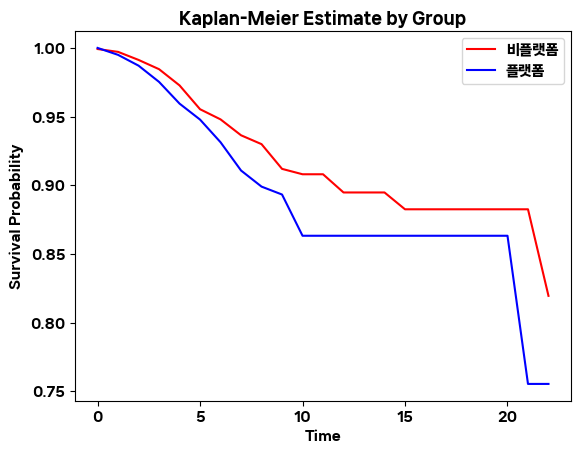

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.89 0.03      5.21

None


In [210]:
kmf = KaplanMeierFitter()

# 데이터를 그룹별로 모델에 적합
for group in sa_df2_in21y['platform'].unique():
    group_data = sa_df2_in21y[sa_df2_in21y['platform'] == group]
    kmf.fit(group_data['time'], event_observed=group_data['event'], label=group)
    ax=plt.subplot()
    kmf.survival_function_.plot(ax=ax)
    #    kmf.plot(label=group)

# 생존 곡선 시각화
plt.title('Kaplan-Meier Estimate by Group')
plt.rc("font", family="NanumSquare Neo OTF Heavy")
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# 각 그룹별로 다른 색상 설정
colors = ['r', 'b']  # 각 그룹별로 원하는 색상을 선택할 수 있습니다
for i, line in enumerate(plt.gca().get_lines()):
    line.set_color(colors[i])

plt.legend(loc='best')    
plt.show()

# 로그랭크 테스트 수행
results = logrank_test(sa_df2_in21y['time'][sa_df2_in21y['platform'] == '플랫폼'], sa_df2_in21y['time'][sa_df2_in21y['platform'] == '비플랫폼'],
                      event_observed_A=sa_df2_in21y['event'][sa_df2_in21y['platform'] == '플랫폼'],
                      event_observed_B=sa_df2_in21y['event'][sa_df2_in21y['platform'] == '비플랫폼'])

print(results.print_summary())

In [144]:
# 데이터를 모델에 적합
kmf.fit(sa_df2_in21y[sa_df2_in21y['platform']=='플랫폼']['time'], event_observed=sa_df2_in21y[sa_df2_in21y['platform']=='플랫폼']['event'])

# 생존비율 구하기
survival_probability = kmf.survival_function_

# 누적 생존비율 구하기
cumulative_survival_probability = kmf.predict(sa_df2_in21y['time'])

# 결과 출력
print("생존비율:")
print(survival_probability)

생존비율:
               플랫폼
timeline          
0.0       1.000000
1.0       0.995042
2.0       0.987099
3.0       0.975301
4.0       0.954376
5.0       0.943135
6.0       0.928670
7.0       0.903076
8.0       0.885219
9.0       0.877521
10.0      0.854876
11.0      0.847442
12.0      0.835990
13.0      0.835990
14.0      0.835990
15.0      0.835990
16.0      0.835990
17.0      0.835990
18.0      0.835990
19.0      0.835990
20.0      0.835990
21.0      0.743102
22.0      0.743102
23.0      0.743102


In [145]:
# 데이터를 모델에 적합
kmf.fit(sa_df2_in21y[sa_df2_in21y['platform']=='비플랫폼']['time'], event_observed=sa_df2_in21y[sa_df2_in21y['platform']=='비플랫폼']['event'])

# 생존비율 구하기
survival_probability = kmf.survival_function_

# 누적 생존비율 구하기
cumulative_survival_probability = kmf.predict(sa_df2_in21y['time'])

# 결과 출력
print("생존비율:")
print(survival_probability)

생존비율:
               플랫폼
timeline          
0.0       0.999191
1.0       0.997167
2.0       0.990966
3.0       0.984197
4.0       0.970196
5.0       0.953447
6.0       0.938501
7.0       0.924899
8.0       0.914892
9.0       0.900068
10.0      0.897107
11.0      0.897107
12.0      0.882155
13.0      0.875621
14.0      0.875621
15.0      0.865556
16.0      0.865556
17.0      0.865556
18.0      0.865556
19.0      0.865556
20.0      0.865556
21.0      0.865556
22.0      0.824339
23.0      0.824339


### 00~18년 설립

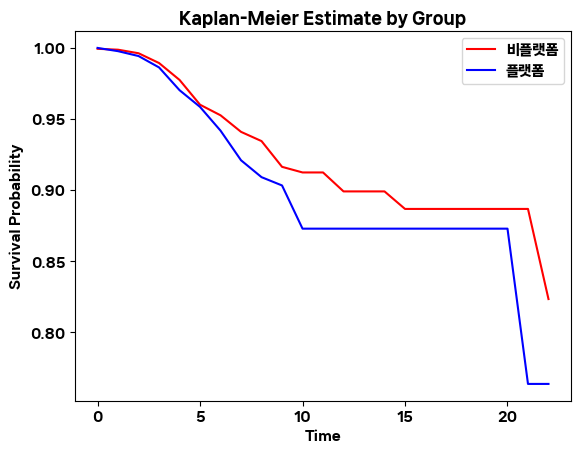

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.34 0.13      2.99

None


In [211]:
kmf = KaplanMeierFitter()

# 데이터를 그룹별로 모델에 적합
for group in sa_df2_in19y['platform'].unique():
    group_data = sa_df2_in19y[sa_df2_in19y['platform'] == group]
    kmf.fit(group_data['time'], event_observed=group_data['event'], label=group)
    ax=plt.subplot()
    kmf.survival_function_.plot(ax=ax)
    #    kmf.plot(label=group)

# 생존 곡선 시각화
plt.title('Kaplan-Meier Estimate by Group')
plt.rc("font", family="NanumSquare Neo OTF Heavy")
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# 각 그룹별로 다른 색상 설정
colors = ['r', 'b']  # 각 그룹별로 원하는 색상을 선택할 수 있습니다
for i, line in enumerate(plt.gca().get_lines()):
    line.set_color(colors[i])

plt.legend(loc='best')    
plt.show()

# 로그랭크 테스트 수행
results = logrank_test(sa_df2_in19y['time'][sa_df2_in19y['platform'] == '플랫폼'], sa_df2_in19y['time'][sa_df2_in19y['platform'] == '비플랫폼'],
                      event_observed_A=sa_df2_in19y['event'][sa_df2_in19y['platform'] == '플랫폼'],
                      event_observed_B=sa_df2_in19y['event'][sa_df2_in19y['platform'] == '비플랫폼'])

print(results.print_summary())